In [ ]:
#tipos de casas:
#castelo - castle
#iglu - igloo
#cabana - hut


obs: adicionei as coisas do quinto capítulo, mas não sei se piorou ou melhorou. mas pelo menos está funcionando. 

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', 'e6c303f4168e494b81536613658455fc')

In [4]:
results = search_images_bing(key, 'castle')
imsCastle = results.attrgot('content_url')
len(imsCastle)

150

In [5]:
ims = ['https://th.bing.com/th/id/OIP.I7TADkd5wEI1vTOLuZe0qQHaEo?pid=ImgDet&rs=1']

In [7]:
import os
os.mkdir('images')
dest = 'images/castle.jpg'
download_url(ims[0], dest)

In [8]:
houses_types = 'castle','igloo','hut'
path = Path('houses')

In [9]:
if not path.exists():
    path.mkdir()
    for o in houses_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o}')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [10]:
fns = get_image_files(path)
fns

(#413) [Path('houses/igloo/00000025.jpg'),Path('houses/igloo/00000144.jpg'),Path('houses/igloo/00000084.jpg'),Path('houses/igloo/00000040.jpg'),Path('houses/igloo/00000036.jpg'),Path('houses/igloo/00000121.jpg'),Path('houses/igloo/00000002.jpg'),Path('houses/igloo/00000009.jpg'),Path('houses/igloo/00000073.jpg'),Path('houses/igloo/00000117.jpg')...]

In [11]:
failed = verify_images(fns)
failed

(#0) []

In [12]:
failed.map(Path.unlink);

In [13]:
houses = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [14]:
dls = houses.dataloaders(path)


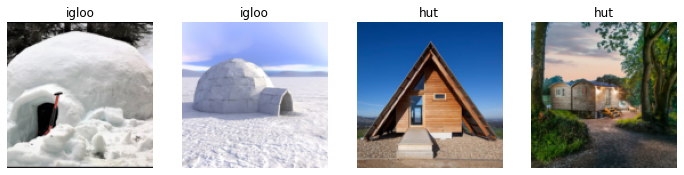

In [15]:
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
#não sei se os códigos dos blocos abaixo são necessários pro treinamento do modelo ou se servem apenas pra visualizar. na dúvida, coloquei.

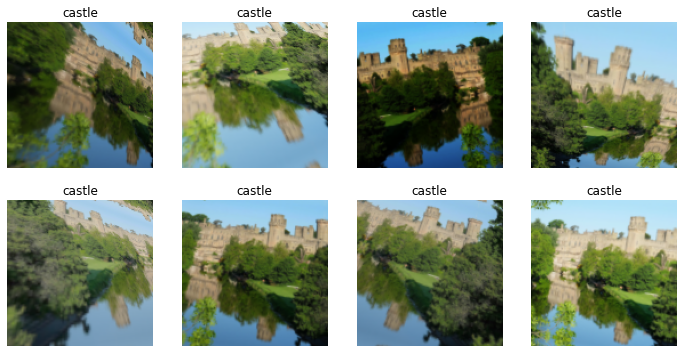

In [16]:
houses = houses.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = houses.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [17]:
houses = houses.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = houses.dataloaders(path)

In [18]:

learn = cnn_learner(dls, resnet34, metrics=error_rate) 
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.682787,0.197233,0.085366,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.381368,0.075563,0.024390,00:14
1,0.272755,0.080273,0.024390,00:14
2,0.189572,0.095178,0.024390,00:14
3,0.146543,0.083961,0.024390,00:14


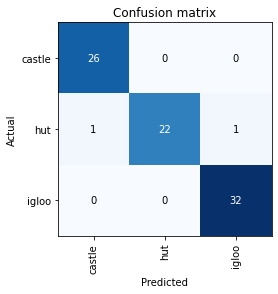

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

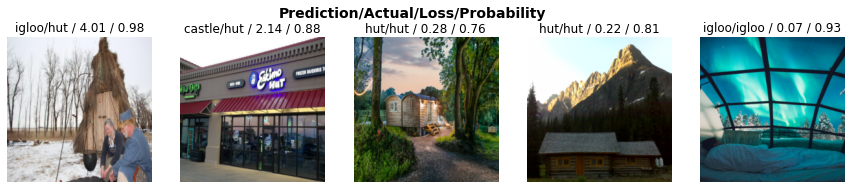

In [20]:
interp.plot_top_losses(5, nrows=1)

In [21]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [20]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

------------- cap 5 ------------------

In [22]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)


epoch,train_loss,valid_loss,error_rate,time
0,0.614725,2.422553,0.170732,00:14


epoch,train_loss,valid_loss,error_rate,time
0,2.989751,40789.730469,0.658537,00:14


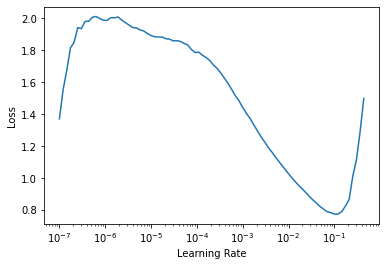

In [23]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find()

In [24]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.00e-02, steepest point: 8.32e-04


In [25]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=2e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.534672,0.362258,0.121951,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.333936,0.121662,0.060976,00:14
1,0.253277,0.120395,0.048780,00:14


In [26]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 2e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.148095,0.329201,0.109756,00:14
1,0.647473,0.064395,0.024390,00:14
2,0.439385,0.065815,0.012195,00:13


In [27]:
learn.unfreeze()

SuggestedLRs(lr_min=0.00014454397605732084, lr_steep=3.981071586167673e-06)

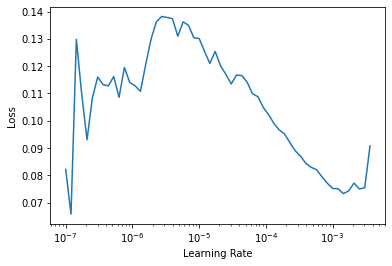

In [28]:
learn.lr_find()

In [29]:
learn.fit_one_cycle(3, lr_max=1e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.117157,0.177048,0.085366,00:14
1,0.099493,0.200073,0.085366,00:14
2,0.070862,0.135284,0.073171,00:14


In [30]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(1, 2e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.060598,0.338798,0.097561,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.471053,0.196407,0.073171,00:14
1,0.390191,0.128850,0.048780,00:14
2,0.355241,0.094146,0.048780,00:14
3,0.314334,0.077848,0.012195,00:14
4,0.281021,0.067427,0.000000,00:14
5,0.267531,0.062119,0.012195,00:14
6,0.245353,0.059291,0.012195,00:14
7,0.220589,0.058943,0.012195,00:15
8,0.207043,0.054498,0.012195,00:14
9,0.191322,0.054767,0.012195,00:14


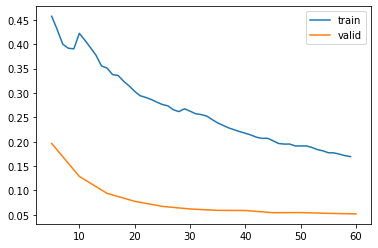

In [31]:
learn.recorder.plot_loss()

-------------------------- cap 5 -----------------------

In [32]:
learn.export()

In [33]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [34]:
learn_inf = load_learner(path/'export.pkl')

In [35]:
learn_inf.predict('houses/castle/00000000.jpg')

('castle', tensor(0), tensor([9.9998e-01, 1.7842e-06, 1.3586e-05]))

In [36]:
learn_inf.dls.vocab

['castle', 'hut', 'igloo']

In [37]:
btn_upload = widgets.FileUpload()
##btn_upload

In [38]:
##img = PILImage.create(btn_upload.data[-1])

In [39]:
out_pl = widgets.Output()
out_pl.clear_output()
##with out_pl: display(img.to_thumb(128,128))
##out_pl

In [ ]:
##pred,pred_idx,probs = learn_inf.predict(img)

In [40]:
lbl_pred = widgets.Label()
##lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
##lbl_pred

In [41]:
btn_run = widgets.Button(description='Classify')
##btn_run

In [42]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [43]:
btn_upload = widgets.FileUpload()

In [44]:
VBox([widgets.Label('Select your house!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

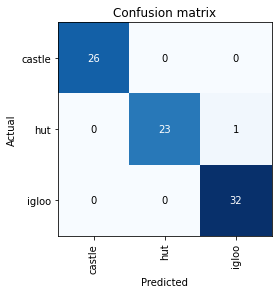

In [45]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [46]:
#isso tem no livro (transformar o notebook em um app) -> teriamos que fazer?
#hide
!pip install voila
!jupyter serverextension enable --sys-prefix voila 

     |████████████████████████████████| 1.6MB 7.5MB/s 
     |████████████████████████████████| 552kB 16.2MB/s 
     |████████████████████████████████| 378kB 23.0MB/s 
     |████████████████████████████████| 122kB 41.5MB/s 
     |████████████████████████████████| 71kB 11.1MB/s 
     |████████████████████████████████| 430kB 35.8MB/s 
ERROR: nbdev 1.1.14 has requirement nbconvert<6, but you'll have nbconvert 6.0.7 which is incompatible.
ERROR: google-colab 1.0.0 has requirement tornado~=5.1.0; python_version >= "3.0", but you'll have tornado 6.1 which is incompatible.
  Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1
  Found existing installation: tornado 5.1.1
    Uninstalling tornado-5.1.1:
      Successfully uninstalled tornado-5.1.1
  Found existing installation: jupyter-client 5.3.5
    Uninstalling jupyter-client-5.3.5:
      Successfully uninstalled jupyter-client-5.3.5


Enabling: voila
- Writing config: /usr/etc/jupyter
    - Validating...
Error loading server extension voila
      X is voila importable?
